In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, \
latent_code_generator_two_layers, latent_code_discriminator, latent_code_generator

from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats
from tf_lab.point_clouds.convenience import get_latent_codes
from tf_lab.neural_net import MODEL_SAVER_ID

from tf_lab.point_clouds.raw_gan_gp import RawGAN_GP
from tf_lab.point_clouds.generators_discriminators import latent_code_generator

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
n_pc_points = 2048
# random_seed = 42
do_training = True
plot_train_curve = True 
save_synthetic_samples = False
save_model = False
max_epochs = 500
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, max_epochs+1, 50)])
class_name = raw_input('Give me the class type.\n').lower()
syn_id = snc_category_to_synth_id()[class_name]
ae_loss = 'emd'
do_wgan = False
b_neck = int(raw_input('Give me bneck_size.\n'))
ae_experiment_tag = 'mlp_with_split_1pc_usampled_bnorm_on_encoder_only'
special_tag = 'denser_sampling'

Give me the class type.
chair
Give me bneck_size.
128


In [7]:
if do_wgan:
    gan_tag = 'l_w_gan'
else:
    gan_tag = 'l_gan'

experiment_tag = '_'.join([gan_tag, class_name, ae_experiment_tag, ae_loss, 'bneck', str(b_neck)])

if special_tag is not None:
    experiment_tag += '_' + special_tag

print experiment_tag

l_gan_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_denser_sampling


In [8]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)
train_data = in_data['train']

679 pclouds were loaded. They belong in 1 shape-classes.
5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [9]:
synthetic_data_out_dir = osp.join(top_data_dir, 'OUT/iclr/synthetic_samples/', gan_tag, experiment_tag)
create_dir(synthetic_data_out_dir)
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models', experiment_tag)
create_dir(train_dir)

'/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/l_gan_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_denser_sampling'

In [10]:
# Load Auto-Encoder
ae_id = '_'.join(['ae', class_name, ae_experiment_tag, str(n_pc_points), 'pts', str(b_neck), 'bneck', ae_loss])
ae_train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/', ae_id)
ae_conf = Conf.load(osp.join(ae_train_dir, 'configuration'))
saved_epochs = read_saved_epochs(ae_conf.train_dir)
_, best_epoch = find_best_validation_epoch_from_train_stats(osp.join(ae_train_dir, 'train_stats.txt'))
if best_epoch % ae_conf.saver_step != 0: # Model was not saved at that epoch.
    best_epoch += best_epoch % ae_conf.saver_step
ae_conf.encoder_args['verbose'] = False
ae_conf.decoder_args['verbose'] = False
reset_tf_graph()
ae = PointNetAutoEncoder(ae_conf.experiment_name, ae_conf)    
ae.restore_model(ae_conf.train_dir, best_epoch, verbose=True)

Model restored in epoch 400.


In [11]:
# Convert raw-data to latent codes.
latent_codes = get_latent_codes(ae, train_data.point_clouds)
train_data = PointCloudDataSet(latent_codes)

In [16]:
init_lr = 0.0001
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = b_neck
n_syn_samples = train_data.num_examples
n_out = [b_neck]
accum_syn_data = []
train_stats = []

In [17]:
reset_tf_graph()

if do_wgan:
    lam = 10
    beta = 0.5
    reset_tf_graph()
    gan = RawGAN_GP(experiment_tag, init_lr, lam, n_out, noise_dim, \
                    latent_code_discriminator_two_layers, latent_code_generator_two_layers,\
                    beta=beta                    
                   )
                    # latent_code_discriminator, , latent_code_generator,
#                     gen_kwargs={'layer_sizes': [64, 128], 'b_norm': False}, 
#                     disc_kwargs={'layer_sizes': [512, 1024], 'b_norm': False})
else:
    beta = 0.5
    gan = LatentGAN(experiment_tag, init_lr, n_out, noise_dim,
                    latent_code_discriminator_two_layers, latent_code_generator_two_layers,
                    beta=beta
                   )

In [18]:
save_synthetic_samples

False

In [19]:
if do_training:
    for _ in range(max_epochs):
        loss, duration = gan._single_epoch_train(train_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss
        
        if save_model and (epoch % saver_step == 0 or epoch <= 5):
            checkpoint_path = osp.join(train_dir, MODEL_SAVER_ID)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        
        if save_synthetic_samples and epoch in saver_step:
            syn_latent_data = gan.generate(n_syn_samples, noise_params)
            syn_data = ae.decode(syn_latent_data)
            np.savez(osp.join(synthetic_data_out_dir, 'epoch_' + str(epoch)), syn_data)
            for k in range(3):
                Point_Cloud(syn_data[k]).plot()
            
        train_stats.append((epoch,) + loss)

1 (0.41234670566475912, 1.9826304430546968)
2 (0.092744595168725311, 3.7401423350624414)
3 (0.086751907124467523, 4.9079365854677945)
4 (0.14127983541592307, 5.5437571193860924)
5 (0.11072289509617764, 6.0356144200200621)
6 (0.057010742665632913, 6.0249628647514015)
7 (0.034189508660979896, 6.2511722398840863)
8 (0.02702255496836227, 6.6130070810732633)
9 (0.028049864069275236, 6.6683759316154152)
10 (0.039642552173008092, 6.2399310899817424)
11 (0.067302263495714762, 5.3281164915665338)
12 (0.095872920589602506, 4.6584717170051908)
13 (0.11670367102260175, 4.179448787025783)
14 (0.13206631431113119, 3.9878793301789659)
15 (0.16565291175375815, 3.8262052411618441)
16 (0.2338887218547904, 3.6161000645678976)
17 (0.31642804664114249, 3.3541466132454252)
18 (0.4007429537565812, 3.000937961495441)
19 (0.50492612304894824, 2.6533821873042895)
20 (0.60389162457507595, 2.2986403237218442)
21 (0.69011772767357205, 2.038876848635466)
22 (0.76728998733603437, 1.8087486132331516)
23 (0.8442868419

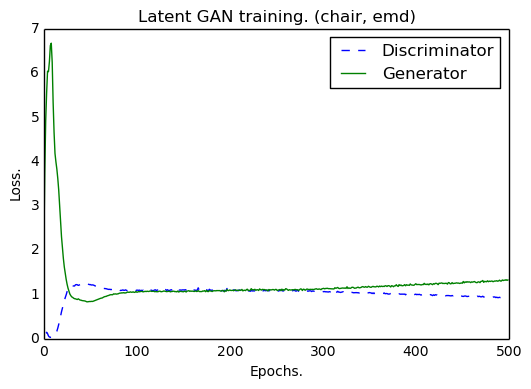

In [20]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')